In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        pass
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torchvision import transforms,datasets
from torch.utils.data import Dataset
from torch.utils.data import DataLoader,random_split

**Step0:** Data Processing

In [3]:
train_path = "/kaggle/input/emotion-detection-fer/train"
test_path  = "/kaggle/input/emotion-detection-fer/test"

trans      = transforms.Compose([transforms.Resize((224,224)),
                                 transforms.Grayscale(num_output_channels=1),
                                 transforms.ToTensor()])

train_data = []
for folder in os.listdir(train_path):
    folder_path = os.path.join(train_path,folder)
    for img in os.listdir(folder_path):
        train_data .append(os.path.join(folder_path,img))

test_data = []
for folder in os.listdir(test_path):
    folder_path = os.path.join(test_path,folder)
    for img in os.listdir(folder_path):
        test_data .append(os.path.join(folder_path,img))

print(len(train_data ), len(test_data))

28709 7178


torch.Size([1, 224, 224])
/kaggle/input/emotion-detection-fer/test/fearful/im308.png


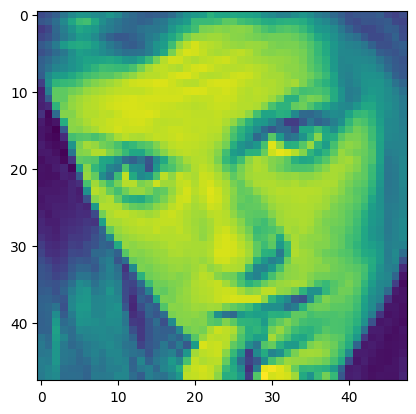

In [4]:
from PIL import Image
img = Image.open(test_data[10])
img_tensor = trans(img)
print(img_tensor.size())
plt.imshow(Image.open(test_data[10]))
print(test_data[10])

['angry', 'disgusted', 'fearful', 'happy', 'neutral', 'sad', 'surprised']


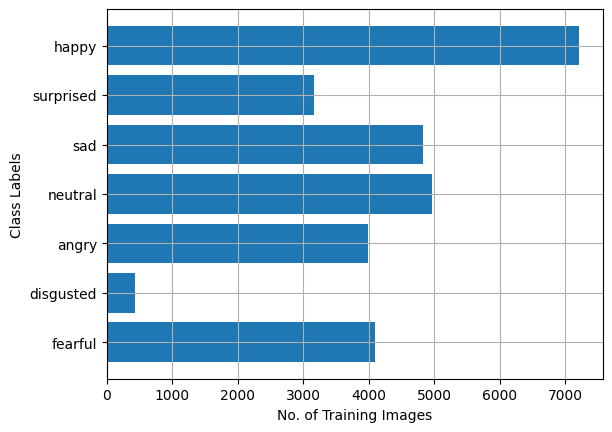

In [5]:
train_dataset = datasets.ImageFolder(train_path,trans)
print(train_dataset.classes)
train_dataset[0][0].size()
# out=trans(train_dataset[0])

class_counts = dict()
for subfolder in os.listdir(train_path):
    class_counts[subfolder] = len(os.listdir(os.path.join(train_path,subfolder)))
plt.barh(list(class_counts.keys()),class_counts.values())
plt.xlabel("No. of Training Images")
plt.ylabel("Class Labels")
plt.grid()

**Step1:**Defining the Hyperparameters

In [6]:
bs = 32
learning_rate =0.0001
num_epochs = 12
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [7]:
from torch.utils.data import random_split
train_size = int(0.7 * len(train_dataset))  # 70% for training
val_size = len(train_dataset) - train_size   # 30% for validation

# Use random_split to create the training and validation sets
train, val = random_split(train_dataset, [train_size, val_size])

train_dataloader = DataLoader(train,batch_size=bs,shuffle=True)
val_dataloader   = DataLoader(val,batch_size=bs,shuffle=False)


In [8]:
dataloader_iter = next(iter(train_dataloader))
dataloader_iter[0][0].size()

torch.Size([1, 224, 224])

**Step2:** Creating a Model

In [9]:
import torch.nn as nn
import torch.nn.functional as F

#Define Model
class EmotionDetection(nn.Module):
    def __init__(self,num_classes):
        super(EmotionDetection, self).__init__()
        #Since we are converting image to gray scale use input channel as 1
        self.conv1 = nn.Conv2d(1, 64, kernel_size=11, stride=4)
        self.pool1 = nn.MaxPool2d(kernel_size=3, stride=2)
        self.norm1 = nn.BatchNorm2d(64)
        
        nn.Dropout(0.25),
        
        self.conv2 = nn.Conv2d(64, 192, kernel_size=5, padding=2)
        self.pool2 = nn.MaxPool2d(kernel_size=3, stride=2)
        self.norm2 = nn.BatchNorm2d(192)

        nn.Dropout(0.25),
        
        self.conv3 = nn.Conv2d(192, 384, kernel_size=3, padding=1)

        self.conv4 = nn.Conv2d(384, 256, kernel_size=3, padding=1)

        self.conv5 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool2d(kernel_size=3, stride=2)
        self.norm3 = nn.BatchNorm2d(256)

        
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))

        self.fc = nn.Sequential(
            nn.Dropout(0.25),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes)
        )

    def forward(self, x):
#         print(x.size())
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = self.norm1(x)
        
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = self.norm2(x)
        
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = F.relu(self.conv5(x))

        x = self.pool3(x)
        x = self.norm3(x)
        x = self.avgpool(x)

        
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

model = EmotionDetection(7)
model = model.to(device)
model.parameters

<bound method Module.parameters of EmotionDetection(
  (conv1): Conv2d(1, 64, kernel_size=(11, 11), stride=(4, 4))
  (pool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (norm2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (norm3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (avgpool): AdaptiveAvgPool2d(output

**Step3:** Define Loss Function and Optimizer

In [10]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(),lr=learning_rate)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer,gamma=0.5)


In [11]:
#Check for type of device
device

device(type='cuda')

**Step4:** Training Loop

In [12]:
def compute_accuracy(outputs,labels):
    _,predictions = torch.max(outputs,1)
    return (predictions==labels).sum().item()

**Complete Train Loop**

In [13]:
from tqdm import tqdm
train_acc=[]
val_acc  =[]

for epoch in tqdm(range(num_epochs)):
    num_correct  = 0
    total_samples=0
    model.train()
    for inputs,labels in train_dataloader:
        #Push to device
        labels=labels.to(device)
        inputs=inputs.to(device)
        
        #Forward Pass
        outputs = model(inputs)
        loss = criterion(outputs,labels)
        #backward Pass
        optimizer.zero_grad()
        loss.backward()
        #Update
        optimizer.step()
        
        total_samples+=len(labels)
        num_correct  += compute_accuracy(outputs,labels)
    train_accuracy=num_correct/total_samples
    train_acc.append(train_accuracy)
    scheduler.step()

    
    #Validate
    model.eval()    
    with torch.no_grad():
        num_correct=0
        total_samples=0
        for inputs,labels in val_dataloader:
            inputs=inputs.to(device)
            labels=labels.to(device)
            outputs=model(inputs)
            num_correct+=compute_accuracy(outputs,labels)
            total_samples+=len(labels)
        val_accuracy = num_correct*100/total_samples
        val_acc.append(val_accuracy)
    print(f"Loss = {loss} Training Accuracy = {train_accuracy} Validation Accuracy = {val_accuracy}%")    
        
    

  8%|▊         | 1/12 [03:28<38:09, 208.16s/it]

Loss = 1.1991827487945557 Training Accuracy = 0.43536027070063693 Validation Accuracy = 50.493440148612564%


 17%|█▋        | 2/12 [04:58<23:07, 138.70s/it]

Loss = 1.0286353826522827 Training Accuracy = 0.5773785828025477 Validation Accuracy = 55.59038662486938%


 25%|██▌       | 3/12 [06:27<17:24, 116.09s/it]

Loss = 1.046762466430664 Training Accuracy = 0.6539609872611465 Validation Accuracy = 58.4000928828515%


 33%|███▎      | 4/12 [07:56<14:04, 105.57s/it]

Loss = 0.8262578845024109 Training Accuracy = 0.7244725318471338 Validation Accuracy = 60.780215952629746%


 42%|████▏     | 5/12 [09:26<11:38, 99.77s/it] 

Loss = 0.5870799422264099 Training Accuracy = 0.7830911624203821 Validation Accuracy = 62.17345872518286%


 50%|█████     | 6/12 [10:55<09:37, 96.29s/it]

Loss = 0.3334886133670807 Training Accuracy = 0.8168292197452229 Validation Accuracy = 62.13862765586904%


 58%|█████▊    | 7/12 [12:25<07:50, 94.04s/it]

Loss = 0.5602645874023438 Training Accuracy = 0.8334992038216561 Validation Accuracy = 61.91803088354813%


 67%|██████▋   | 8/12 [13:54<06:10, 92.60s/it]

Loss = 0.653776228427887 Training Accuracy = 0.8411624203821656 Validation Accuracy = 62.103796586555205%


 75%|███████▌  | 9/12 [15:24<04:35, 91.74s/it]

Loss = 0.5751107335090637 Training Accuracy = 0.8484275477707006 Validation Accuracy = 61.91803088354813%


 83%|████████▎ | 10/12 [16:54<03:02, 91.11s/it]

Loss = 0.5253847241401672 Training Accuracy = 0.8482782643312102 Validation Accuracy = 61.97608266573784%


 92%|█████████▏| 11/12 [18:23<01:30, 90.50s/it]

Loss = 0.38210681080818176 Training Accuracy = 0.8513634554140127 Validation Accuracy = 61.96447230929989%


100%|██████████| 12/12 [19:52<00:00, 99.37s/it]

Loss = 0.4721032977104187 Training Accuracy = 0.8506170382165605 Validation Accuracy = 61.76709624985487%


In [14]:
epoch_list = list(range(num_epochs))
train_acc,val_acc


([0.43536027070063693,
  0.5773785828025477,
  0.6539609872611465,
  0.7244725318471338,
  0.7830911624203821,
  0.8168292197452229,
  0.8334992038216561,
  0.8411624203821656,
  0.8484275477707006,
  0.8482782643312102,
  0.8513634554140127,
  0.8506170382165605],
 [50.493440148612564,
  55.59038662486938,
  58.4000928828515,
  60.780215952629746,
  62.17345872518286,
  62.13862765586904,
  61.91803088354813,
  62.103796586555205,
  61.91803088354813,
  61.97608266573784,
  61.96447230929989,
  61.76709624985487])

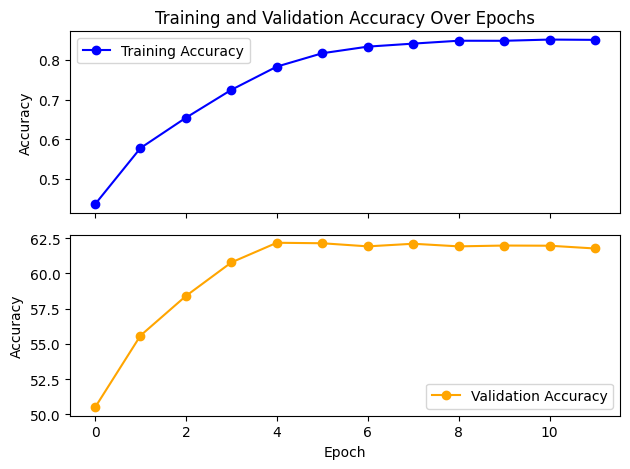

In [15]:
import matplotlib.pyplot as plt

# Create subplots
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)

# Plot Training Accuracy
ax1.plot(epoch_list, train_acc, label='Training Accuracy', marker='o', color='blue')
ax1.set_ylabel('Accuracy')
ax1.set_title('Training and Validation Accuracy Over Epochs')
ax1.legend()

# Plot Validation Accuracy
ax2.plot(epoch_list, val_acc, label='Validation Accuracy', marker='o', color='orange')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend()

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()


Test Accuracy & Confusion Matrix

In [16]:
orignal_labels=[]
predicted_labels=[]

with torch.no_grad():
    model.eval()
    num_correct=0
    total_samples=0
    for inputs,labels in val_dataloader:
        inputs=inputs.to(device)
        labels=labels.to(device)
        outputs=model(inputs)
        num_correct+=compute_accuracy(outputs,labels)
        total_samples+=len(labels)
        
        _,predictions = torch.max(outputs,1)
        predictions=predictions.cpu().detach().tolist()
        labels=labels.cpu().detach().tolist()
        predicted_labels.extend(predictions)
        orignal_labels.extend(labels)
        
#         print(f"Num Correct = {num_correct} Length Labels={len(labels)}")
print(f"Accuracy = {num_correct*100/total_samples}%")    
    

Accuracy = 61.76709624985487%


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


[[ 638   14  125   76  146  187   25]
 [  30   49   20    4    3   23    6]
 [ 160    7  499   73  122  244  105]
 [  65    1   46 1808  113   92   35]
 [ 122    1   92  133  879  260   21]
 [ 149    4  169   89  268  741   14]
 [  22    4  100   65   35   23  706]]


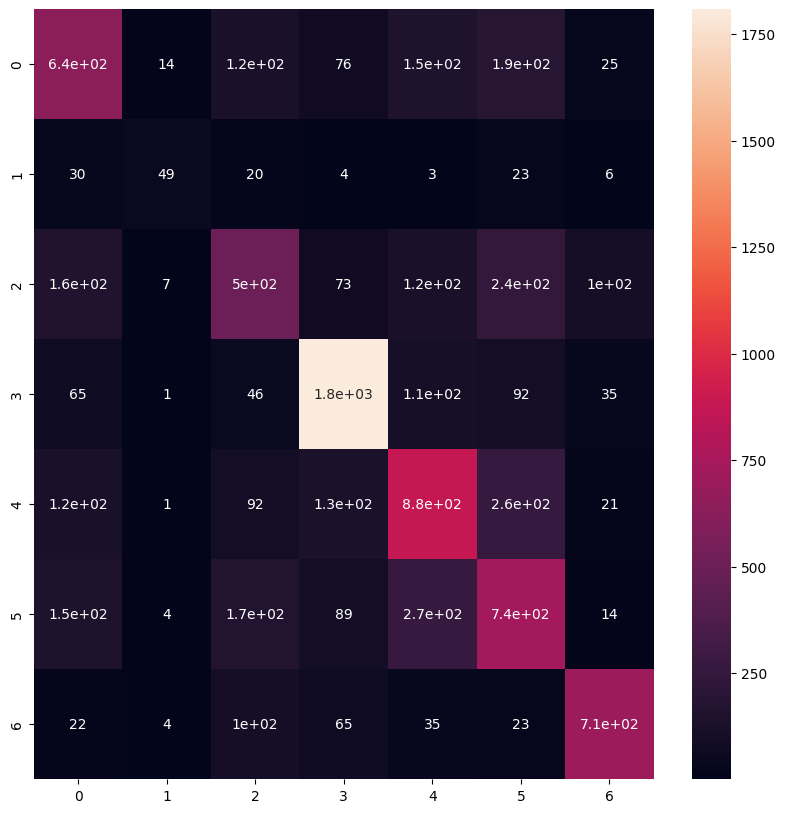

In [17]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

plt.figure(figsize=(10,10))
Conf_matrix = confusion_matrix(y_true=orignal_labels,y_pred=predicted_labels)
sns.heatmap(Conf_matrix,annot=True)
print(Conf_matrix)

**Saving Model**

In [18]:
torch.save(model.state_dict(),'Emotion_Detection.pt')

**Loading and Inference of model**

In [19]:
net = EmotionDetection(7)
net.load_state_dict(torch.load("Emotion_Detection.pt"))
net = net.to(device)
net

EmotionDetection(
  (conv1): Conv2d(1, 64, kernel_size=(11, 11), stride=(4, 4))
  (pool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (norm2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (norm3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (fc): Sequential(
 

In [20]:
import os
import cv2
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import math
os.chdir('/kaggle/input/harasscascade-frontal-face-classifier')
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
face_cascade

< cv2.CascadeClassifier 0x7cf25c858ff0>

In [21]:
def predict_with_labels(image, face_cascade):
    image = np.array(image)
    print("Processing")
    gray_image = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    # plt.imshow(gray_image)
    # plt.show()
    faces = face_cascade.detectMultiScale(gray_image)

    if len(faces) == 0:
        cv2.putText(image, "No Faces Detected", (50,50), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255,0,0), 2, cv2.LINE_AA)
    else:
      # Process each detected face
          print(f"number of faces{len(faces)}")
          for x, y, w, h in faces:
            print(x,y,w,h)
            if w>20 or h>20:
                # Extract the region of interest (ROI) for each face
                roi_color = image[y:y+h, x:x+w]

                # Draw a rectangle around each face
                cv2.rectangle(image, (x, y), (x+w, y+h), (0, 255, 0), 5)

                #Transform image before passing to model
                trans_image = trans(Image.fromarray(roi_color, mode='RGB'))
                trans_image = trans_image.unsqueeze(0)

                # Predict image for each face
                with torch.no_grad():
                    trans_image = trans_image.to(device)
                    output = net(trans_image)
                    _, prediction = torch.max(output, 1)

                classes = ['angry', 'disgusted', 'fearful', 'happy', 'neutral', 'sad', 'surprised']
                label = classes[prediction.item()]

                # Add class label with white background on top of each detected rectangle

            FONT_SCALE = 2e-2  # Adjust for larger font size in all images
            THICKNESS_SCALE = 1e-2  # Adjust for larger thickness in all images
            font_scale = min(w, h) * FONT_SCALE
            thickness = math.ceil(max(w, h) * THICKNESS_SCALE)

            cv2.putText(image, label, (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, font_scale, (255,0,0), thickness, cv2.LINE_AA)

            print(label)
    plt.imshow(image)
    plt.show()


Processing
number of faces1
445 847 1794 1794
disgusted


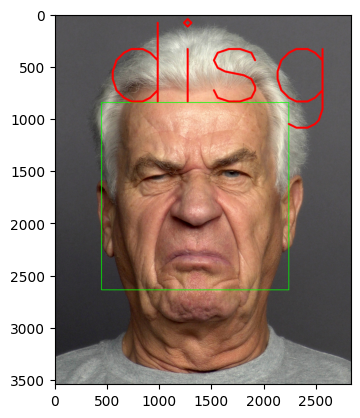

In [22]:
img = Image.open("/kaggle/input/facial-expression/004_o_m_d_b.jpg")
predict_with_labels(img,face_cascade)